In [1]:
library("here")
library(devtools)
library(Seurat)
library(harmony)
library(RcppML)
library(reshape2)
library(tidyverse)
load_all('/home/jpm73279/Socrates')
data_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/QC_output/"

set.seed(12345)



here() starts at /home/jpm73279/Mendieta_et_al_comparative_single_cell

Loading required package: usethis

Attaching SeuratObject

Attaching sp

Loading required package: Rcpp

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
Warning message:
“package ‘ggplot2’ was built under R version 4.2.1”
Warning message:
“package ‘tibble’ was built under R version 4.2.1”
Warning message:
“package ‘purrr’ was built under R version 4.2.1”
Warning message:
“package ‘stringr’ was built under R version 4.2.1”
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [2]:

library(randomcoloR)
other <- randomcoloR::distinctColorPalette(k = 55)
other <- sample(other)

In [3]:
# bed <- system.file("extdata", "test.tn5.bed.gz", package = "Socrates")
#ann <- system.file("extdata", "gencode.v19.annotation.gff3.gz", package = "Socrates")
#chr <- system.file("extdata", "hg19.txt", package = "Socrates")

reference_genome_path <- "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/"
analysis_path <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/sorghum_bicolor/"

sb_leaf_rep_1 <- paste0(analysis_path, "Sorghum_leaf.sciATAC.merged.unique.tn5.sorted.bed")

# set-up arguments

#ann <- "Zm-B73-REFERENCE-NAM-5.0_Zm00001eb.1.nuclear.gff3"
#chr <- "Zm-B73-REFERENCE-NAM-5.0.chrom.size"
#pre <- "Sb.Leaf_rep1"
#output <- as.character(args[5])

ann <- paste0(reference_genome_path,"Sbicolorv5.1.primaryTrs.gff3")
chr <- paste0(reference_genome_path,"Sorghum_bicolor_var_BTx623.chrom.size")
pre <- "Sb.Leaf_merged_reps"



#Load Object
Sb.subcluster <- loadBEDandGenomeData(sb_leaf_rep_1, ann, chr)
#zea_m.rep.peaks  <- paste0(pre, "macs2_temp", sep=".")

Running pre-check on input files and executable paths ...

BED file path = /scratch/jpm73279/comparative_single_cell/01.alignments_annotations/sorghum_bicolor/Sorghum_leaf.sciATAC.merged.unique.tn5.sorted.bed ... ok

GFF file path = /home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sbicolorv5.1.primaryTrs.gff3 ... ok

Chromosome sizes file path = /home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sorghum_bicolor_var_BTx623.chrom.size ... ok

Macs2 is installed .... ok

 - loading data (this may take obj while for big BED files) ...

 - finished loading data



In [4]:

marker_list_sb_file <- "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/markers/Sb.leaf_markers_from_zm.markers.txt"
marker_list_sb <- read_delim(marker_list_sb_file, delim='\t', 
                                       col_names = TRUE)

Rows: 151 Columns: 7
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): chr, geneID, name, type, tissue
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
loaded_socrates_data <- readRDS("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/Sb.annotation_V3t.LC_results.rds")

In [6]:

sb.loaded_socrates_data.epidermal <- loaded_socrates_data
cleaned_cluster_meta <- sb.loaded_socrates_data.epidermal$Clusters  %>% 
        group_by(LouvainClusters)  %>% 
        mutate(Louvain_cluster_safe = str_c("LouvainC_", LouvainClusters))
    
sb.loaded_socrates_data.epidermal$Clusters <- cleaned_cluster_meta

## SubClustering Epidermal Lineages:
"LouvainC_2", "LouvainC_12", "LouvainC_20", 
"LouvainC_4", "LouvainC_6", "LouvainC_18",
"LouvainC_15", "LouvainC_1"

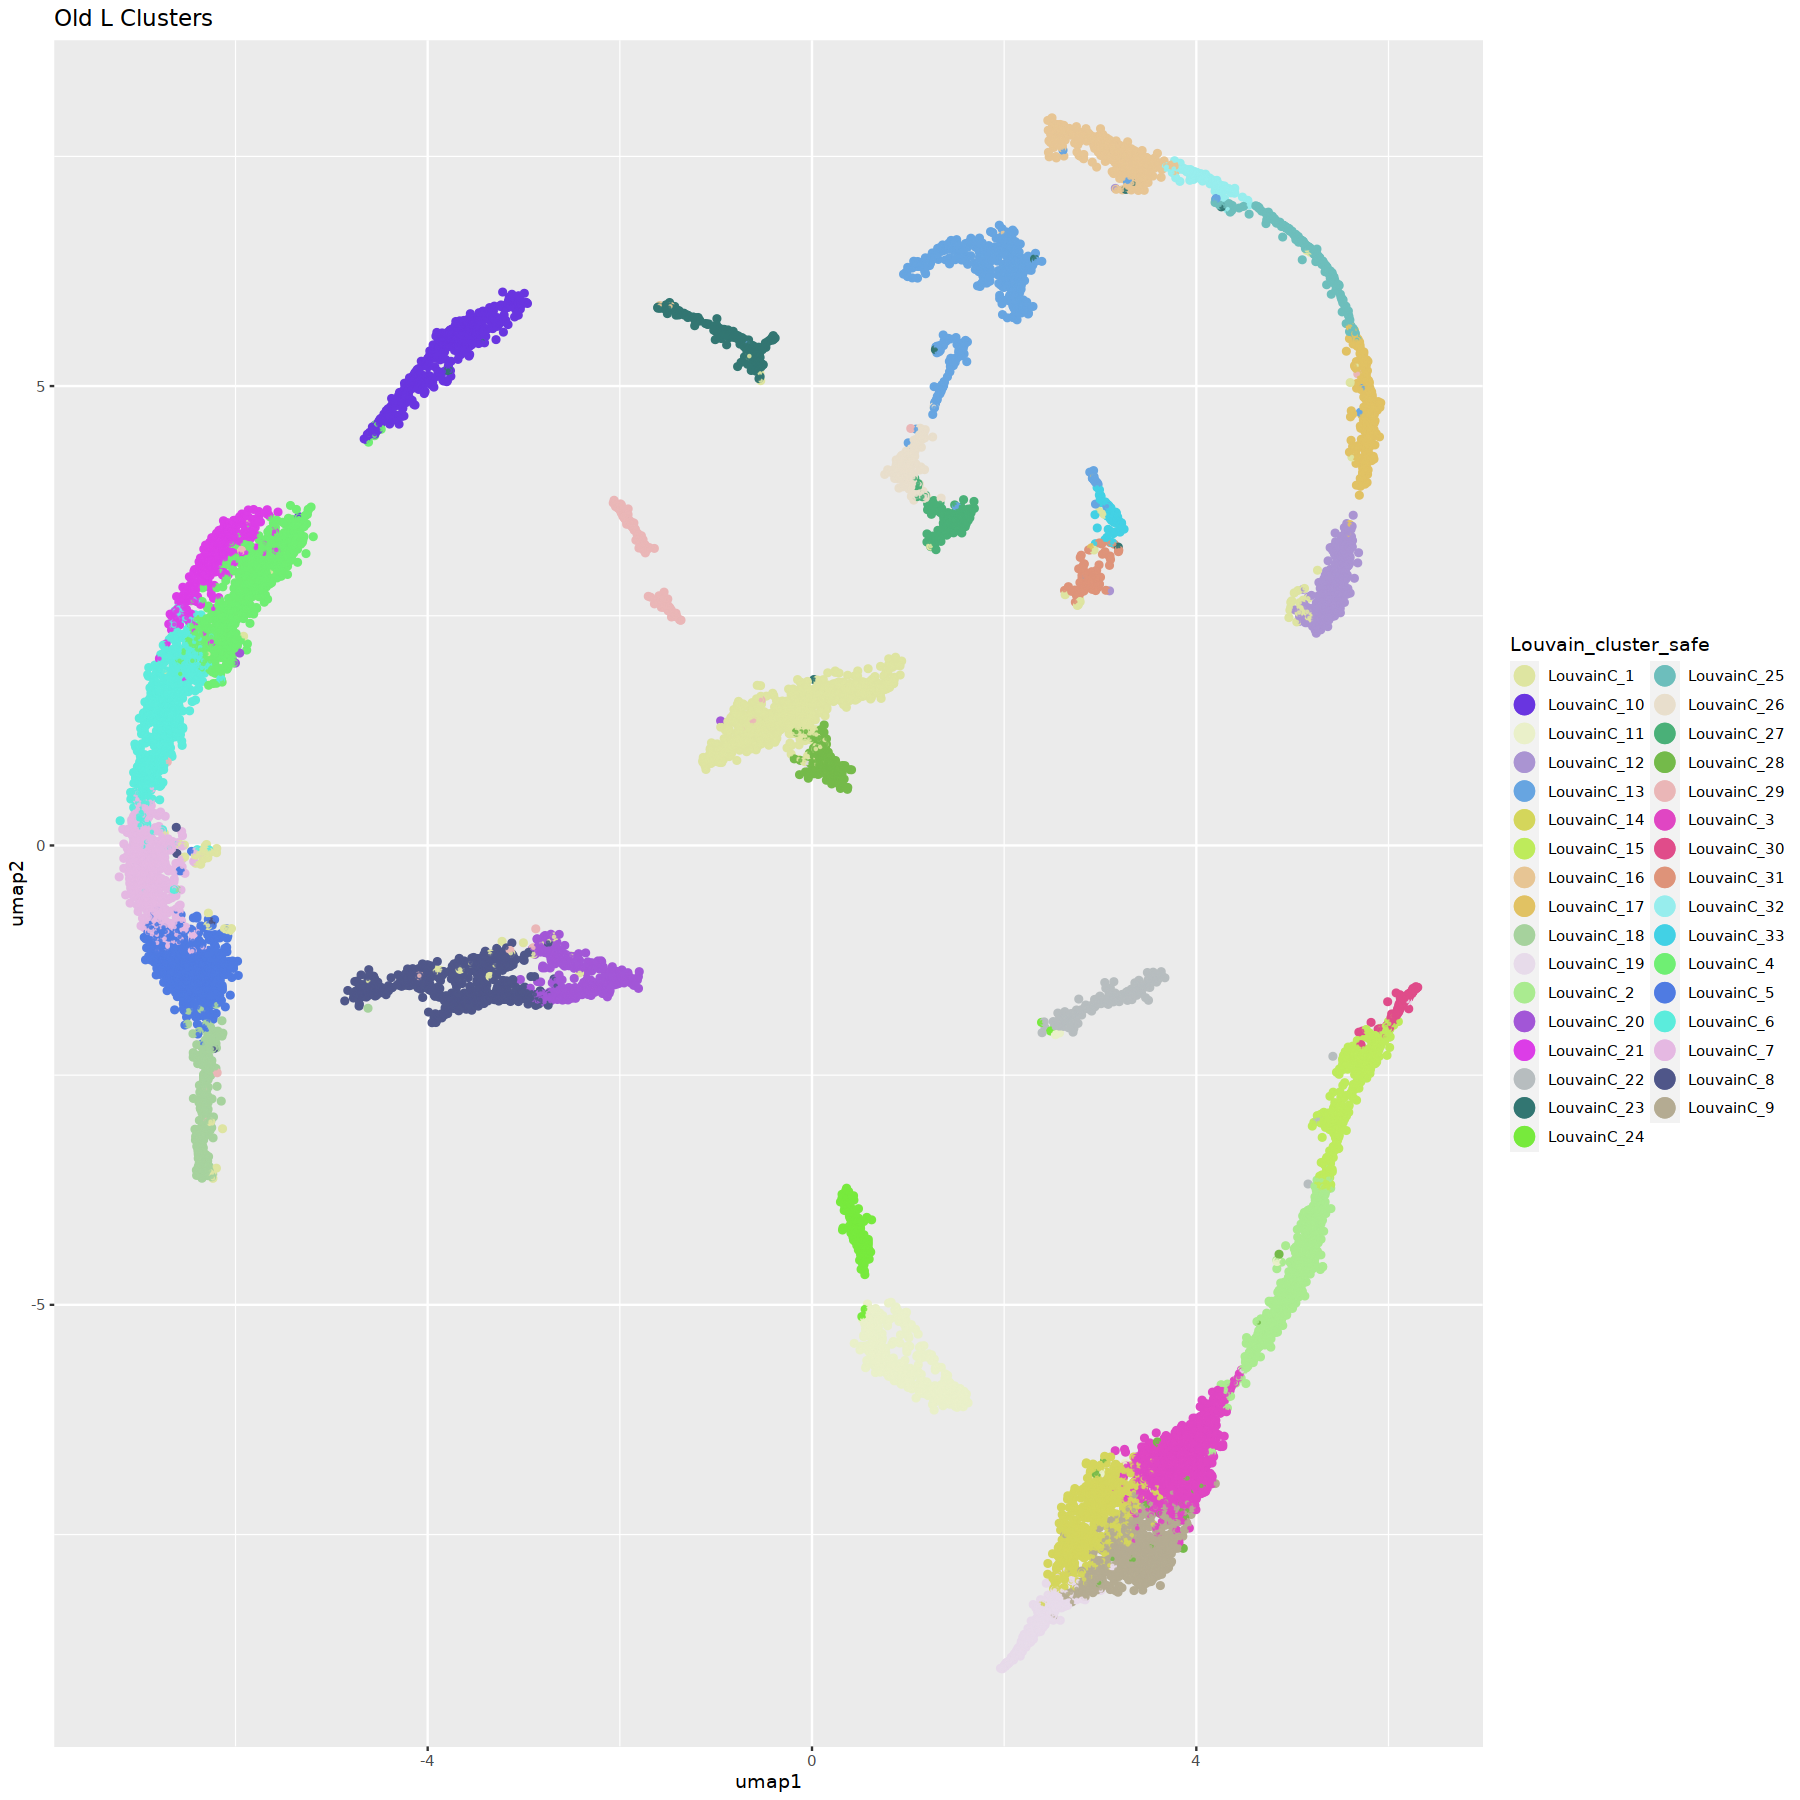

In [13]:
library(cowplot)
library(randomcoloR)
options(repr.plot.width=15, repr.plot.height=15)
other <- randomcoloR::distinctColorPalette(k = 55)
other <- sample(other)


Sb.subcluster.epidermal <- Sb.subcluster


#c("LouvainC_18","LouvainC_5","LouvainC_7","LouvainC_32",
#  "LouvainC_24","LouvainC_21","LouvainC_8","LouvainC_20","LouvainC_23")

sb.loaded_socrates_data.epidermal$Clusters  %>% 
    group_by(Louvain_cluster_safe) %>% 
    ggplot(., aes(umap1, umap2, color = Louvain_cluster_safe)) + geom_point() +
 scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Old L Clusters")

chosen_subcluster <- sb.loaded_socrates_data.epidermal$Clusters

meta_df <- as.data.frame(chosen_subcluster)
rownames(meta_df) <- meta_df$cellID
Sb.subcluster.epidermal$meta <- meta_df
Sb.subcluster.epidermal$meta.v3 <- meta_df

Sb.subcluster.epidermal$acr <- read.table("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/Sb_peak_calls/Sb.peaks/Sb.peaks.500bp_peaks.bed")

In [29]:
Sb.subcluster.epidermal <- generateMatrix(Sb.subcluster.epidermal, 
                                              filtered=FALSE,
                                              peaks = TRUE,
                                              verbose=TRUE)

In [30]:
str(Sb.subcluster.epidermal)

List of 10
 $ bed    :'data.frame':	153098783 obs. of  5 variables:
  ..$ V1: chr [1:153098783] "Chr01" "Chr01" "Chr01" "Chr01" ...
  ..$ V2: int [1:153098783] 149 168 168 168 168 168 168 175 175 176 ...
  ..$ V3: int [1:153098783] 150 169 169 169 169 169 169 176 176 177 ...
  ..$ V4: chr [1:153098783] "BC:Z:CAGATCAGTCAATGTCGGTAGAGACTA-Sorghum_leaf.sciATAC_rep2" "BC:Z:CTTGTAAGTTCCTGTTTGTCCGCTCGG-Sorghum_leaf.sciATAC_rep2" "BC:Z:CTTGTAATGTCAACTCGGGTAGCAGCT-Sorghum_leaf.sciATAC_rep2" "BC:Z:GATCAGCTTGTATGTCGATGAGCTCGG-Sorghum_leaf.sciATAC_rep2" ...
  ..$ V5: chr [1:153098783] "+" "+" "+" "+" ...
 $ gff    :Reference class 'TxDb' [package "GenomicFeatures"] with 6 fields
  ..$ conn           :Formal class 'SQLiteConnection' [package "RSQLite"] with 8 slots
  .. .. ..@ ptr                :<externalptr> 
  .. .. ..@ dbname             : chr ""
  .. .. ..@ loadable.extensions: logi TRUE
  .. .. ..@ flags              : int 70
  .. .. ..@ vfs                : chr ""
  .. .. ..@ ref            

In [48]:
Sb.subcluster.epidermal <- convertSparseData(Sb.subcluster.epidermal, verbose = TRUE)

 - converting triplet format to sparseMatrix



In [50]:
str(Sb.subcluster.epidermal)

List of 2
 $ counts:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:32274877] 4 6 8 9 11 13 14 17 21 27 ...
  .. ..@ p       : int [1:14887] 0 30583 44299 69492 84766 107592 128422 148897 168421 188838 ...
  .. ..@ Dim     : int [1:2] 67812 14886
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:67812] "Chr01_10000914_10001415" "Chr01_100020_100521" "Chr01_10004430_10004931" "Chr01_10010580_10011081" ...
  .. .. ..$ : chr [1:14886] "BC:Z:GCCAATATGTCACTAAGGGTAGCACTA-Sorghum_leaf.sciATAC_rep1" "BC:Z:CGATGTAGTCAACTAAGATTCCTACCG-Sorghum_leaf.sciATAC_rep1" "BC:Z:TTAGGCAGTCAAAAACACGTACGTCGG-Sorghum_leaf.sciATAC_rep1" "BC:Z:ACAGTGCCGTCCCTAAGGTAGAGAGCT-Sorghum_leaf.sciATAC_rep1" ...
  .. ..@ x       : num [1:32274877] 1 1 1 1 1 1 1 1 1 1 ...
  .. ..@ factors : list()
 $ meta  :'data.frame':	14886 obs. of  14 variables:
  ..$ cellID              : chr [1:14886] "BC:Z:GCCAATATGTCACTAAGGGTAGCACTA-Sorghum_leaf.sciATAC_rep1" "BC:Z:CGATGTAGTCAACTAAGATTCCTACCG-Sorghu

In [66]:
# clean sparse counts matrix ---------------------------------------------
Sb.subcluster.epidermal.clean <- cleanData(Sb.subcluster.epidermal, 
                     min.t=0.01,  # minimum feature frequency across cells
                     max.t=0.2, # maximum feature frequency across cells
                     verbose=T)


   * Input: cells = 14886 | peaks = 67812

   * Filtered: cells = 14551 | peaks = 35909



 - non-linear dimensionality reduction with UMAP ...

10:36:40 UMAP embedding parameters a = 1.896 b = 0.8006

10:36:40 Read 14551 rows and found 30 numeric columns

10:36:40 Using Annoy for neighbor search, n_neighbors = 15

10:36:40 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:36:42 Writing NN index file to temp file /tmp/RtmpjYWtWO/file270f144dd3f97

10:36:42 Searching Annoy index using 16 threads, search_k = 1500

10:36:42 Annoy recall = 99.97%

10:36:45 Commencing smooth kNN distance calibration using 16 threads
 with target n_neighbors = 15

10:36:45 5 smooth knn distance failures

10:36:48 Initializing from normalized Laplacian + noise (using irlba)

10:36:48 Commencing optimization for 200 epochs, with 367140 positive edges

10:37:11 Optimization finished

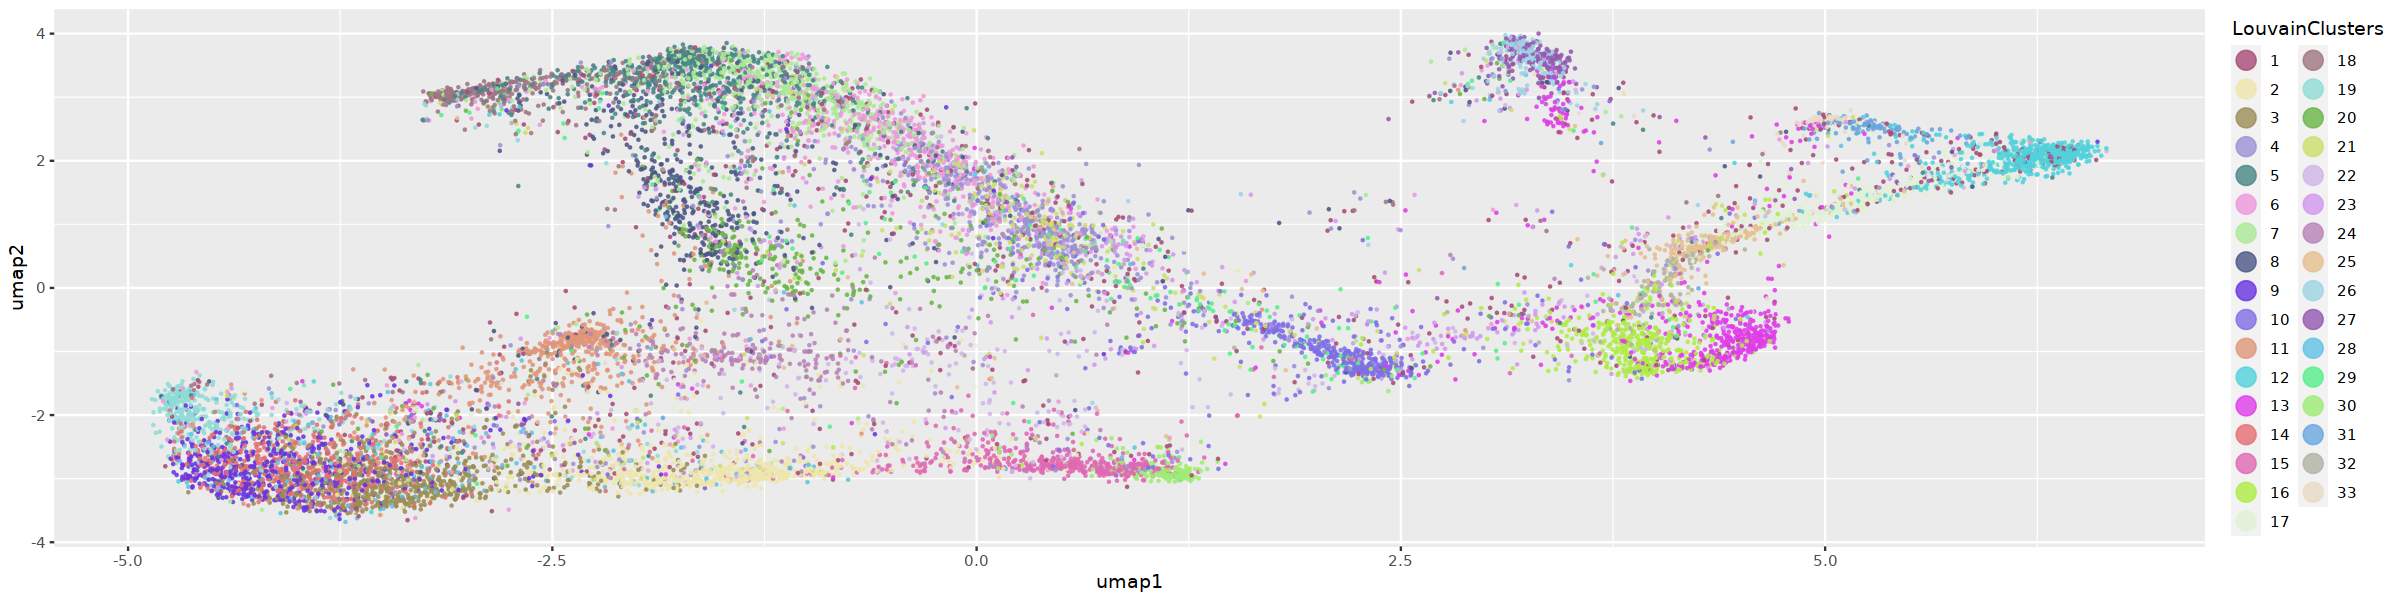

In [67]:
# normalize with TFIDF ---------------------------------------------------
Sb.subcluster.epidermal.tfidf <- tfidf(Sb.subcluster.epidermal.clean)

# project with NMF -------------------------------------------------------
Sb.subcluster.epidermal.tfidf <- reduceDims(Sb.subcluster.epidermal.tfidf,
                      method="SVD", 
                      n.pcs=30, 
                      num.var = 2000,
                      svd_slotName="SVD")

# reduce to 2-dimensions with UMAP ---------------------------------------
Sb.subcluster.epidermal.tfidf <- projectUMAP(Sb.subcluster.epidermal.tfidf, 
                       verbose=T,
                       k.near=15,
                       m.dist=0.01,
                       svd_slotName="SVD")

library(randomcoloR)
other <- randomcoloR::distinctColorPalette(k = 55)
other <- sample(other)

ggplot(Sb.subcluster.epidermal.tfidf$meta, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8)

In [68]:
# identify clusters using neighborhood graph -----------------------------
Sb.subcluster.epidermal.tfidf.clusters <- callClusters(Sb.subcluster.epidermal.tfidf, 
                        res=5,
                        k.near = 15,
                        #min.reads=1000,
                        verbose=T,
                        svd_slotName= "SVD",
                        cluster_slotName="sub_cluster",
                        cleanCluster=FALSE)


 - filtering outliers in UMAP manifold (z-score e.thresh = 3) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14323
Number of edges: 766592

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.5933
Number of communities: 29
Elapsed time: 28 seconds


 - finished graph-based clustering ...

 - filtering clusters with low cell/read counts ...



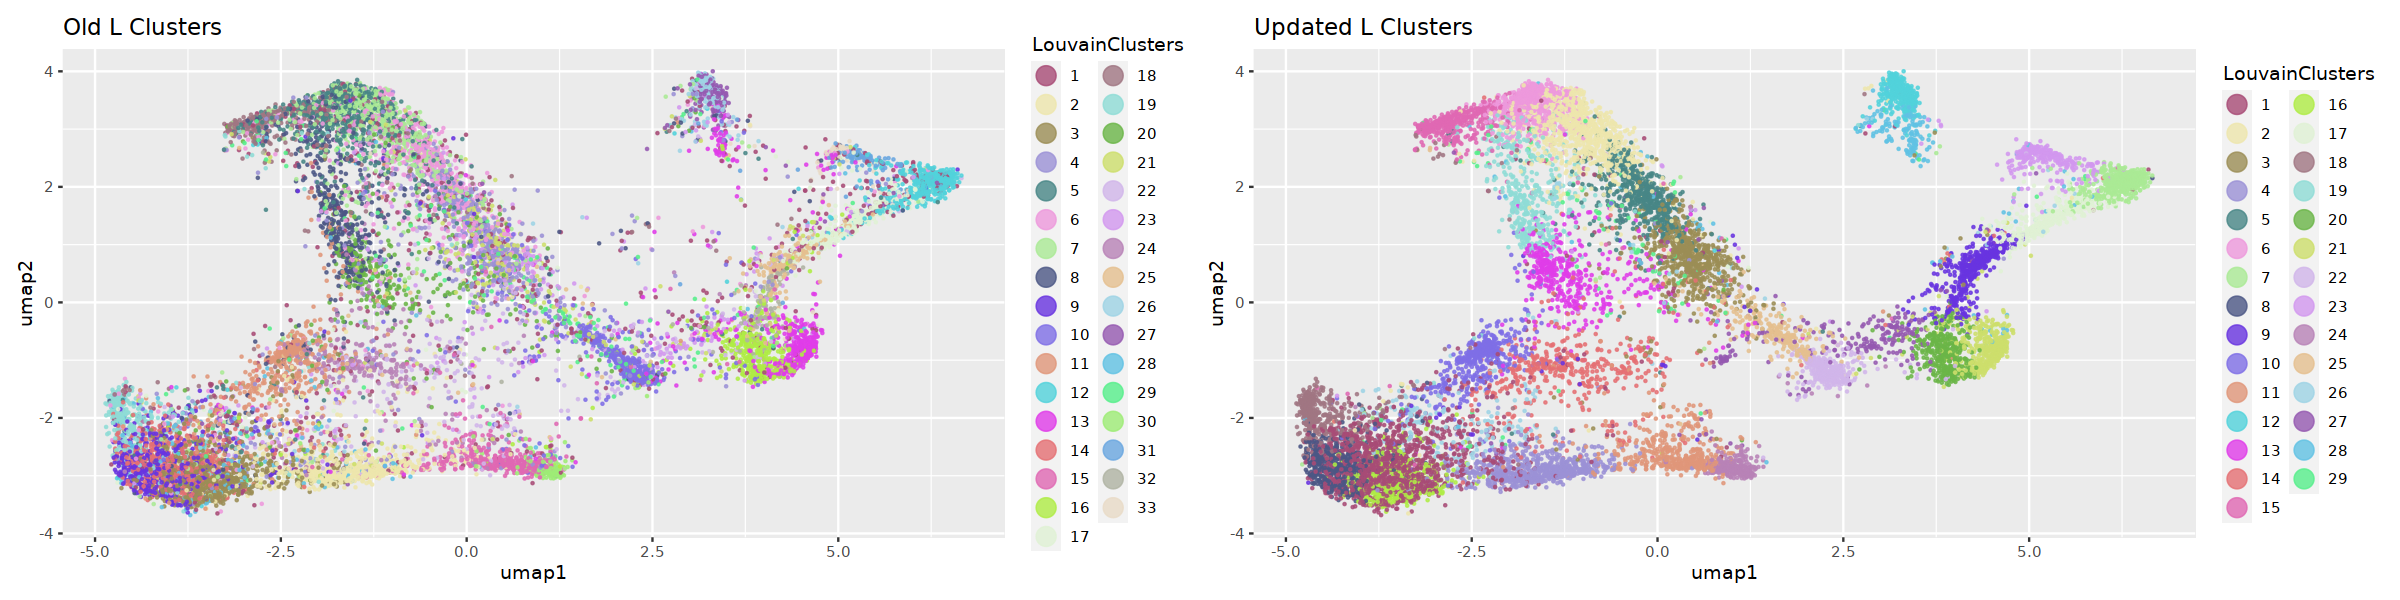

In [69]:
options(repr.plot.width=20, repr.plot.height=5)

old_clusters <- ggplot(Sb.subcluster.epidermal.tfidf.clusters$meta, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8)+ ggtitle("Old L Clusters")

new_clusters <- ggplot(Sb.subcluster.epidermal.tfidf.clusters$sub_cluster, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Updated L Clusters")


old_clusters + new_clusters 

In [70]:
Sb.subcluster.epidermal.tfidf.clusters$sub_cluster  %>% 
    group_by(LouvainClusters)  %>% 
    summarise(n())

LouvainClusters n() 
1  1               1277
2  2                948
3  3                757
4  4                749
5  5                638
6  6                631
7  7                624
8  8                574
9  9                515
10 10               506
11 11               481
12 12               479
13 13               478
14 14               474
15 15               473
16 16               450
17 17               449
18 18               449
19 19               439
20 20               430
21 21               428
22 22               388
23 23               336
24 24               316
25 25               257
26 26               245
27 27               240
28 28               201
29 29                91

In [71]:
sb_annotation_v3 <- read_tsv("/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/Sb_leaf.V3_final.txt", 
                                    )
sb_annotation_v3.final <- sb_annotation_v3  %>% 
    dplyr::select(cellID, V3_final_annnotation)

Rows: 14947 Columns: 25
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (13): cellID, sampleID, d.type, cell_annotation_glmnet, cell_annotation_...
dbl (12): total, tss, acrs, ptmt, nSites, log10nSites, umap1, umap2, doublet...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [73]:


final_joined <- left_join(Sb.subcluster.epidermal.tfidf.clusters$sub_cluster, sb_annotation_v3.final, by = "cellID")


new_clusters <- ggplot(Sb.subcluster.epidermal.tfidf.clusters$sub_cluster, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Updated L Clusters")



new_coords_onld_annot <- ggplot(final_joined, aes(x=umap1, y = umap2, color = V3_final_annnotation)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("V3 Annotation")



In [24]:
setwd("/scratch/jpm73279/comparative_single_cell/dev_location/SB_iter_clusters")
#bed_intersections <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/zea_mays/Zm.all_mergeed_repds.unique.mpq10.tn5.sorted.bed
genome_file <- "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/sb_genmap_output.chrom.sizes"

In [ ]:
# Trying to call Louvain Cluster Peaks on this dataset...

In [26]:
call_per_cluster_ACRs <- function(meta_obj, 
                                  slot_name, 
                                  cluster_name, 
                                  bed_integrations, 
                                  base_output_name="test_Rrun", 
                                  output_dir="test", 
                                  genome_file,
                                  verbose=FALSE){
    
    clust_name <- c(cluster_name)
    
    cell_converted_trible <- as_tibble(meta_obj[[slot_name]])
    
    
    generate_count_data <- cell_converted_trible  %>% 
        group_by(!!sym(clust_name))  %>% 
        summarise(counts_per_clust = n())
    
    print(generate_count_data)
    
    final_tribble <- left_join(cell_converted_trible, generate_count_data)  %>% 
        mutate(cluster_name_final = str_c(!!sym(clust_name), "_ncell_", counts_per_clust))

    
    write_delim(final_tribble, "test_output_name.2.txt", 
            col_names = TRUE, quote = "none", delim = "\t")

    if(verbose){message("Calling peaks for Clusters - This may take some time. Check output terminal for info.")}
    generate_run_command = paste0("python /home/jpm73279/Mendieta_et_al_comparative_single_cell/python_scripts/scATAC/call_scACRs.py -bed ", bed_integrations, 
                                  " -meta ", "test_output_name.2.txt", 
                                  " -col ", "cluster_name_final", 
                                  " -base ", base_output_name, 
                                  " -outdir ", output_dir, 
                                  " -bw yes -fai ", genome_file)
    
    print(generate_run_command)
    system(generate_run_command)

    
    if(verbose){message("Done!")}
    
    output_peak_file_name <- paste0(output_dir, "/", base_output_name, ".500bp_peaks.bed")
    
    meta_obj$acr_file_name <- output_peak_file_name
    return(meta_obj)
    
}


In [33]:
calculate_accessability <- function(meta_obj, 
                                    tn5_integration, 
                                    base_name="idk",
                                    bed_file_load = "acr_file_name",
                                    type = "acr",
                                    output_dir = ".",
                                    output_name="raw_accessability", 
                                    output_slot = "acr_counts_raw"){
    
    peaks <- meta_obj[[bed_file_load]]
    output_file_name <- paste0(output_dir, "/", output_name)
    calculate_accessability <- paste0("python ~/Mendieta_et_al_comparative_single_cell/python_scripts/scATAC/gene_body_acc.py -anno ", peaks, 
                                      " -tn5 ", tn5_integration," -type ", 
                                      type, " -base ", base_name, " -p 10 -o ", output_file_name) 
    
    
    print(calculate_accessability)
    return_code <- system(calculate_accessability,intern = TRUE)
    
    meta_obj[output_slot] <- output_name
    
    return(meta_obj)
    
}

In [ ]:
library(tidyverse)
Sb.subcluster.epidermal.tfidf.clusters.called_clusters <- call_per_cluster_ACRs(Sb.subcluster.epidermal.tfidf.clusters, 
                                                     base_output_name = "Sb.LouvainCluster.iter",
                                                     slot_name = "sub_cluster", 
                                                     cluster_name = "Louvain_cluster_safe",
                                                     bed_integrations = sb_leaf_rep_1, 
                                                     output_dir = "/scratch/jpm73279/comparative_single_cell/dev_location/SB_iter_clusters", 
                                                     genome_file= genome_file)

# A tibble: 33 × 2
   Louvain_cluster_safe counts_per_clust
   <chr>                           <int>
 1 LouvainC_1                        715
 2 LouvainC_10                       563
 3 LouvainC_11                       570
 4 LouvainC_12                       583
 5 LouvainC_13                       503
 6 LouvainC_14                       533
 7 LouvainC_15                       480
 8 LouvainC_16                       453
 9 LouvainC_17                       438
10 LouvainC_18                       402
# … with 23 more rows


Joining, by = "Louvain_cluster_safe"


In [34]:
tfidf.obj.dob.filt.clusters.counts.final <- calculate_accessability(Sb.subcluster.epidermal.tfidf.clusters.called_clusters, 
    sb_leaf_rep_1, 
    base_name = "Sb.LouvainCluster.iter.counts",
    bed_file_load = "acr_file_name",
    type = "acr",
    output_dir = "/scratch/jpm73279/comparative_single_cell/dev_location/SB_iter_clusters",
    output_name = "Sb.acr_counts.output")

[1] "python ~/Mendieta_et_al_comparative_single_cell/python_scripts/scATAC/gene_body_acc.py -anno /scratch/jpm73279/comparative_single_cell/dev_location/SB_iter_clusters/Sb.LouvainCluster.iter.500bp_peaks.bed -tn5 /scratch/jpm73279/comparative_single_cell/01.alignments_annotations/sorghum_bicolor/Sorghum_leaf.sciATAC.merged.unique.tn5.sorted.bed -type acr -base Sb.LouvainCluster.iter.counts -p 10 -o /scratch/jpm73279/comparative_single_cell/dev_location/SB_iter_clusters/Sb.acr_counts.output"


In [20]:
#prefix <- "Sb_leaf.merged_replicates.acr_bins"
#output_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering"

#nmf.rd <- Sb.subcluster.epidermal.tfidf.clusters$SVD
#write.table(nmf.rd, file=paste0(output_location, prefix, ".SVD.full.reduced_dimensions.txt"), quote=F, row.names=T, col.names=T, sep="\t")


# 9/25/2022
Working on clustering the dataset now on peaks called by Louvain Clusters. Interested to see what this looks like. 

In [41]:
chosen_subcluster <- sb.loaded_socrates_data.epidermal$Clusters
meta_df <- as.data.frame(chosen_subcluster)
rownames(meta_df) <- meta_df$cellID

In [43]:
sb.subclusetr_lc_peaks <- Sb.subcluster.epidermal
sb.subclusetr_lc_peaks$meta <- meta_df
sb.subclusetr_lc_peaks$meta.v3 <- meta_df


sb.subclusetr_lc_peaks$acr <- read.table("/scratch/jpm73279/comparative_single_cell/dev_location/SB_iter_clusters/Sb.LouvainCluster.iter.500bp_peaks.bed")
str(sb.subclusetr_lc_peaks)

List of 10
 $ bed    :'data.frame':	153098783 obs. of  5 variables:
  ..$ V1: chr [1:153098783] "Chr01" "Chr01" "Chr01" "Chr01" ...
  ..$ V2: int [1:153098783] 149 168 168 168 168 168 168 175 175 176 ...
  ..$ V3: int [1:153098783] 150 169 169 169 169 169 169 176 176 177 ...
  ..$ V4: chr [1:153098783] "BC:Z:CAGATCAGTCAATGTCGGTAGAGACTA-Sorghum_leaf.sciATAC_rep2" "BC:Z:CTTGTAAGTTCCTGTTTGTCCGCTCGG-Sorghum_leaf.sciATAC_rep2" "BC:Z:CTTGTAATGTCAACTCGGGTAGCAGCT-Sorghum_leaf.sciATAC_rep2" "BC:Z:GATCAGCTTGTATGTCGATGAGCTCGG-Sorghum_leaf.sciATAC_rep2" ...
  ..$ V5: chr [1:153098783] "+" "+" "+" "+" ...
 $ gff    :Reference class 'TxDb' [package "GenomicFeatures"] with 6 fields
  ..$ conn           :Formal class 'SQLiteConnection' [package "RSQLite"] with 8 slots
  .. .. ..@ ptr                :<externalptr> 
  .. .. ..@ dbname             : chr ""
  .. .. ..@ loadable.extensions: logi TRUE
  .. .. ..@ flags              : int 70
  .. .. ..@ vfs                : chr ""
  .. .. ..@ ref            

In [44]:
sb.subclusetr_lc_peaks <- generateMatrix(sb.subclusetr_lc_peaks, 
                                              filtered=FALSE,
                                              peaks = TRUE,
                                              verbose=TRUE)

In [51]:
sb.subclusetr_lc_peaks <- convertSparseData(sb.subclusetr_lc_peaks, verbose = TRUE)

 - converting triplet format to sparseMatrix



In [46]:
str(sb.subclusetr_lc_peaks.sparse)

List of 2
 $ counts:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:30982156] 3 6 8 9 11 12 13 16 20 27 ...
  .. ..@ p       : int [1:14887] 0 29612 42859 67275 81926 103982 124110 143854 162626 182400 ...
  .. ..@ Dim     : int [1:2] 66261 14886
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:66261] "Chr01_10004369_10004870" "Chr01_10008320_10008821" "Chr01_10010256_10010757" "Chr01_10011295_10011796" ...
  .. .. ..$ : chr [1:14886] "BC:Z:GCCAATATGTCACTAAGGGTAGCACTA-Sorghum_leaf.sciATAC_rep1" "BC:Z:CGATGTAGTCAACTAAGATTCCTACCG-Sorghum_leaf.sciATAC_rep1" "BC:Z:TTAGGCAGTCAAAAACACGTACGTCGG-Sorghum_leaf.sciATAC_rep1" "BC:Z:ACAGTGCCGTCCCTAAGGTAGAGAGCT-Sorghum_leaf.sciATAC_rep1" ...
  .. ..@ x       : num [1:30982156] 1 1 1 1 1 1 1 1 1 1 ...
  .. ..@ factors : list()
 $ meta  :'data.frame':	14886 obs. of  14 variables:
  ..$ cellID              : chr [1:14886] "BC:Z:GCCAATATGTCACTAAGGGTAGCACTA-Sorghum_leaf.sciATAC_rep1" "BC:Z:CGATGTAGTCAACTAAGATTCCTACCG-So

In [75]:
# clean sparse counts matrix ---------------------------------------------
sb.subclusetr_lc_peaks.clean <- cleanData(sb.subclusetr_lc_peaks, 
                     min.t=0.05,  # minimum feature frequency across cells
                     max.t=0.4, # maximum feature frequency across cells
                     verbose=T)


   * Input: cells = 14886 | peaks = 66261

   * Filtered: cells = 12713 | peaks = 7628



In [76]:
# normalize with TFIDF ---------------------------------------------------
sb.subclusetr_lc_peaks.tfidf <- tfidf(sb.subclusetr_lc_peaks.clean)

# project with NMF -------------------------------------------------------
sb.subclusetr_lc_peaks.tfidf <- reduceDims(sb.subclusetr_lc_peaks.tfidf,
                      method="SVD", 
                      n.pcs=30, 
                      num.var = 5000,
                      svd_slotName="SVD")

# reduce to 2-dimensions with UMAP ---------------------------------------
sb.subclusetr_lc_peaks.tfidf <- projectUMAP(sb.subclusetr_lc_peaks.tfidf, 
                       verbose=T,
                       k.near=15,
                       m.dist=0.001,
                       svd_slotName="SVD")

library(randomcoloR)
other <- randomcoloR::distinctColorPalette(k = 55)
other <- sample(other)

 - non-linear dimensionality reduction with UMAP ...

10:41:01 UMAP embedding parameters a = 1.929 b = 0.7915

10:41:01 Read 12713 rows and found 29 numeric columns

10:41:01 Using Annoy for neighbor search, n_neighbors = 15

10:41:01 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:41:03 Writing NN index file to temp file /tmp/RtmpjYWtWO/file270f1dc4d165

10:41:03 Searching Annoy index using 16 threads, search_k = 1500

10:41:03 Annoy recall = 100%

10:41:06 Commencing smooth kNN distance calibration using 16 threads
 with target n_neighbors = 15

10:41:09 Initializing from normalized Laplacian + noise (using irlba)

10:41:09 Commencing optimization for 200 epochs, with 302298 positive edges

10:41:29 Optimization finished



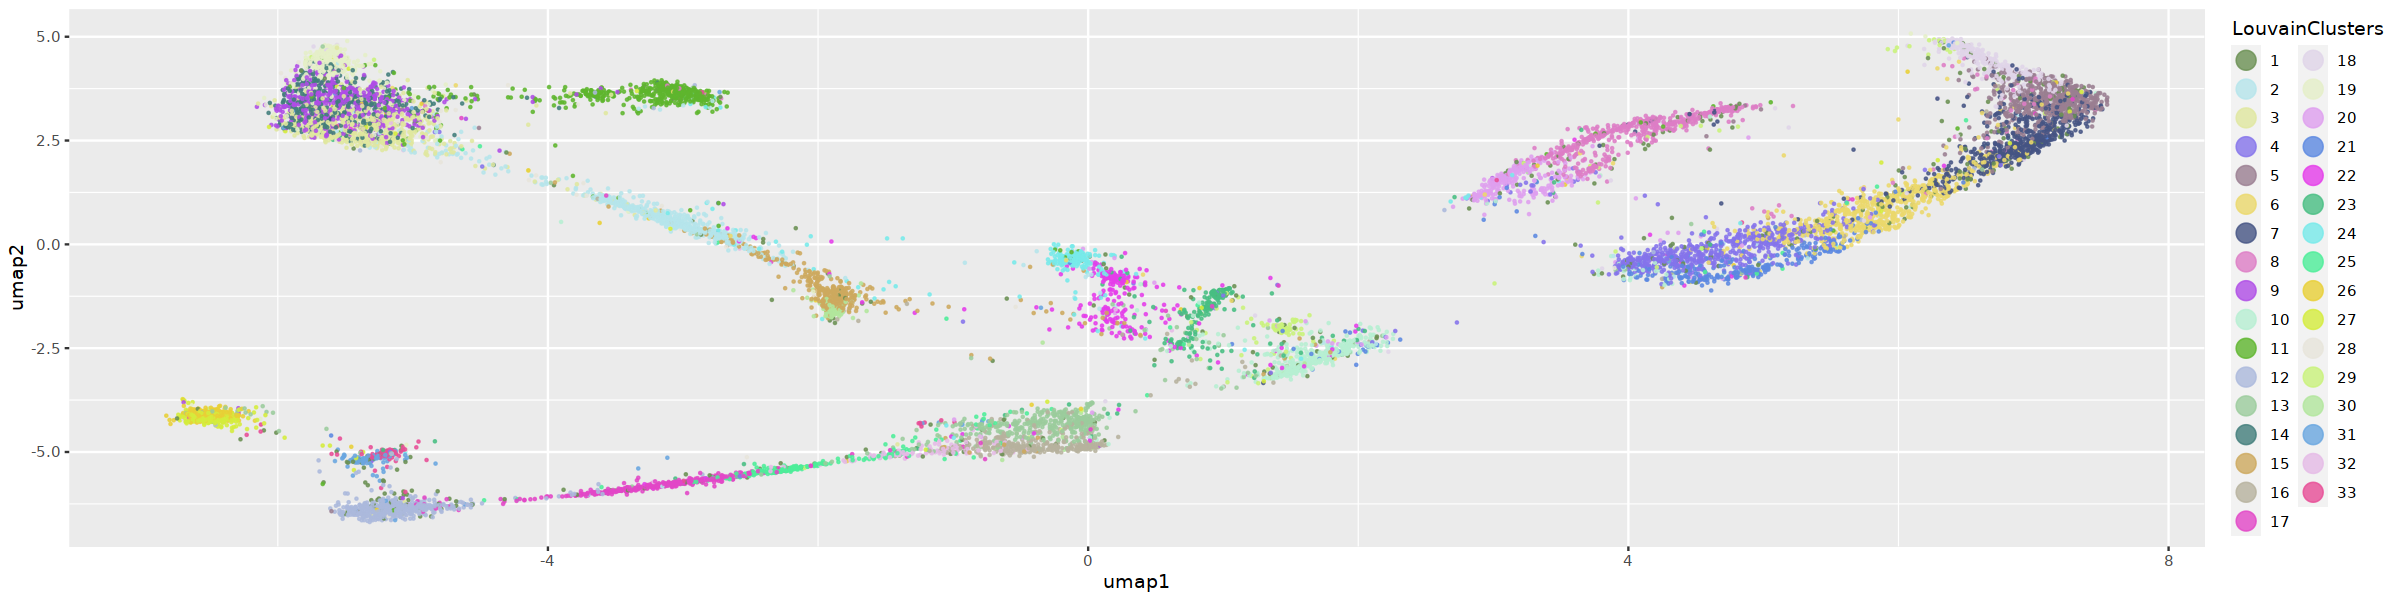

In [77]:
options(repr.plot.width=20, repr.plot.height=5)

ggplot(sb.subclusetr_lc_peaks.tfidf$meta, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8)

In [78]:
# identify clusters using neighborhood graph -----------------------------
sb.subclusetr_lc_peaks.tfidf.clusters <- callClusters(sb.subclusetr_lc_peaks.tfidf, 
                        res=5,
                        k.near = 15,
                        #min.reads=1000,
                        verbose=T,
                        svd_slotName= "SVD",
                        cluster_slotName="sub_cluster",
                        cleanCluster=FALSE)


 - filtering outliers in UMAP manifold (z-score e.thresh = 3) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12475
Number of edges: 590638

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.6609
Number of communities: 31
Elapsed time: 16 seconds


 - finished graph-based clustering ...

 - filtering clusters with low cell/read counts ...



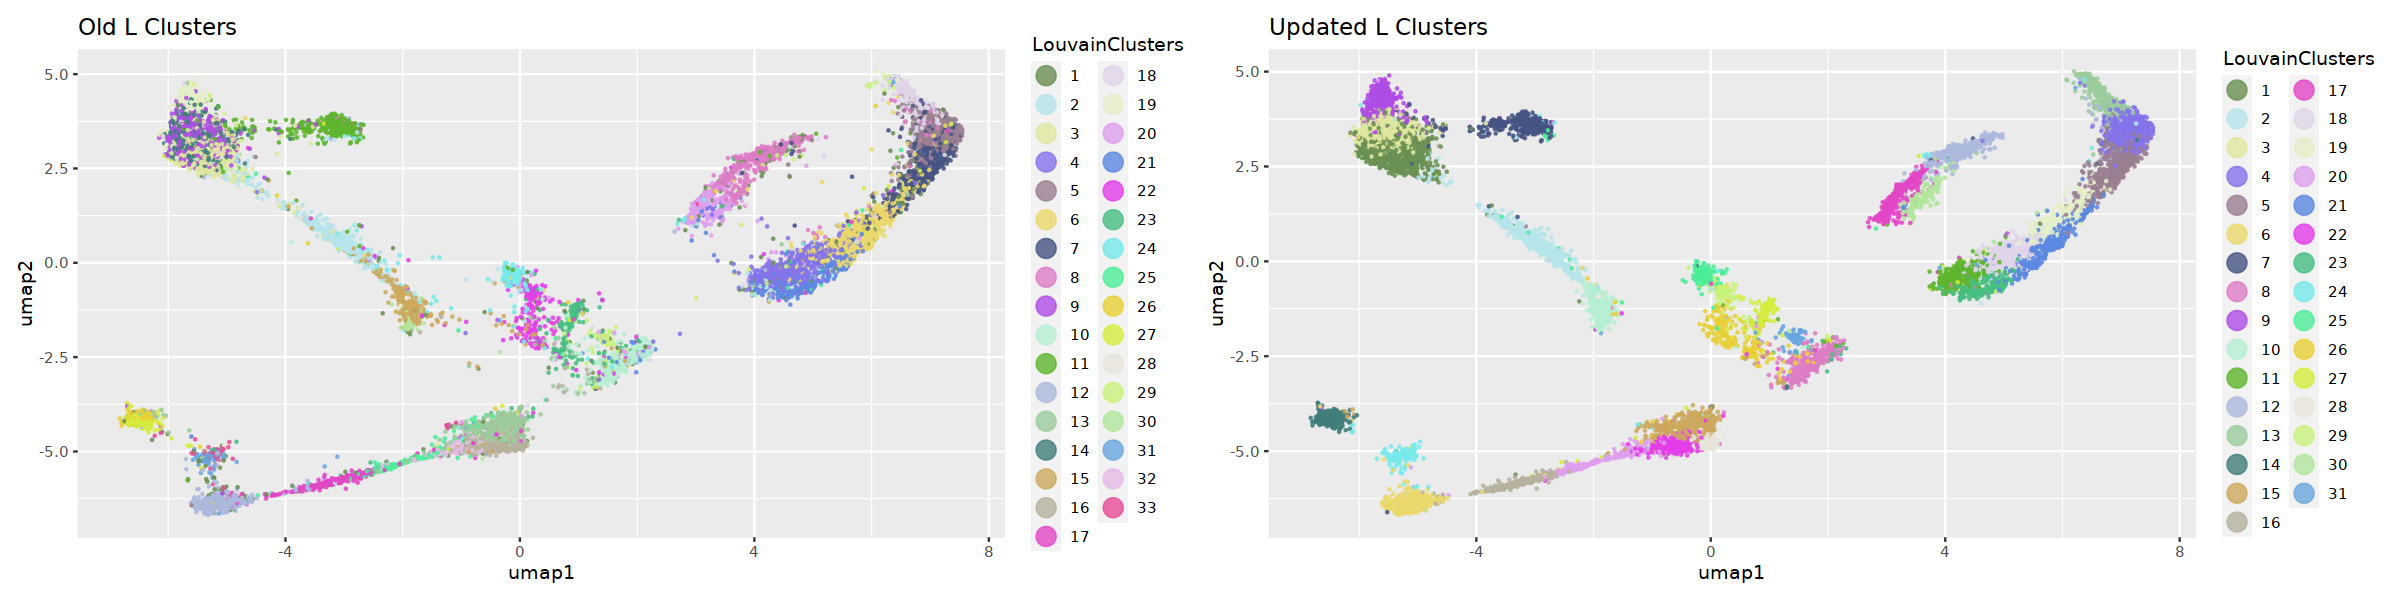

In [79]:
options(repr.plot.width=20, repr.plot.height=5)

old_clusters <- ggplot(sb.subclusetr_lc_peaks.tfidf.clusters$meta, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8)+ ggtitle("Old L Clusters")

new_clusters <- ggplot(sb.subclusetr_lc_peaks.tfidf.clusters$sub_cluster, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Updated L Clusters")


old_clusters + new_clusters 

In [81]:


final_joined <- left_join(sb.subclusetr_lc_peaks.tfidf.clusters$sub_cluster, sb_annotation_v3.final, by = "cellID")


original_clustering <- ggplot(sb_annotation_v3, aes(x=umap1, y = umap2, color = V3_final_annnotation)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .05, alpha = .5) + ggtitle("Original Clustering w/Annotation")



peak_call_2_clustering <- ggplot(final_joined, aes(x=umap1, y = umap2, color = V3_final_annnotation)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .05, alpha = .5) + ggtitle("Peak Clustering Iterative")

#original_clustering + updated_clustering


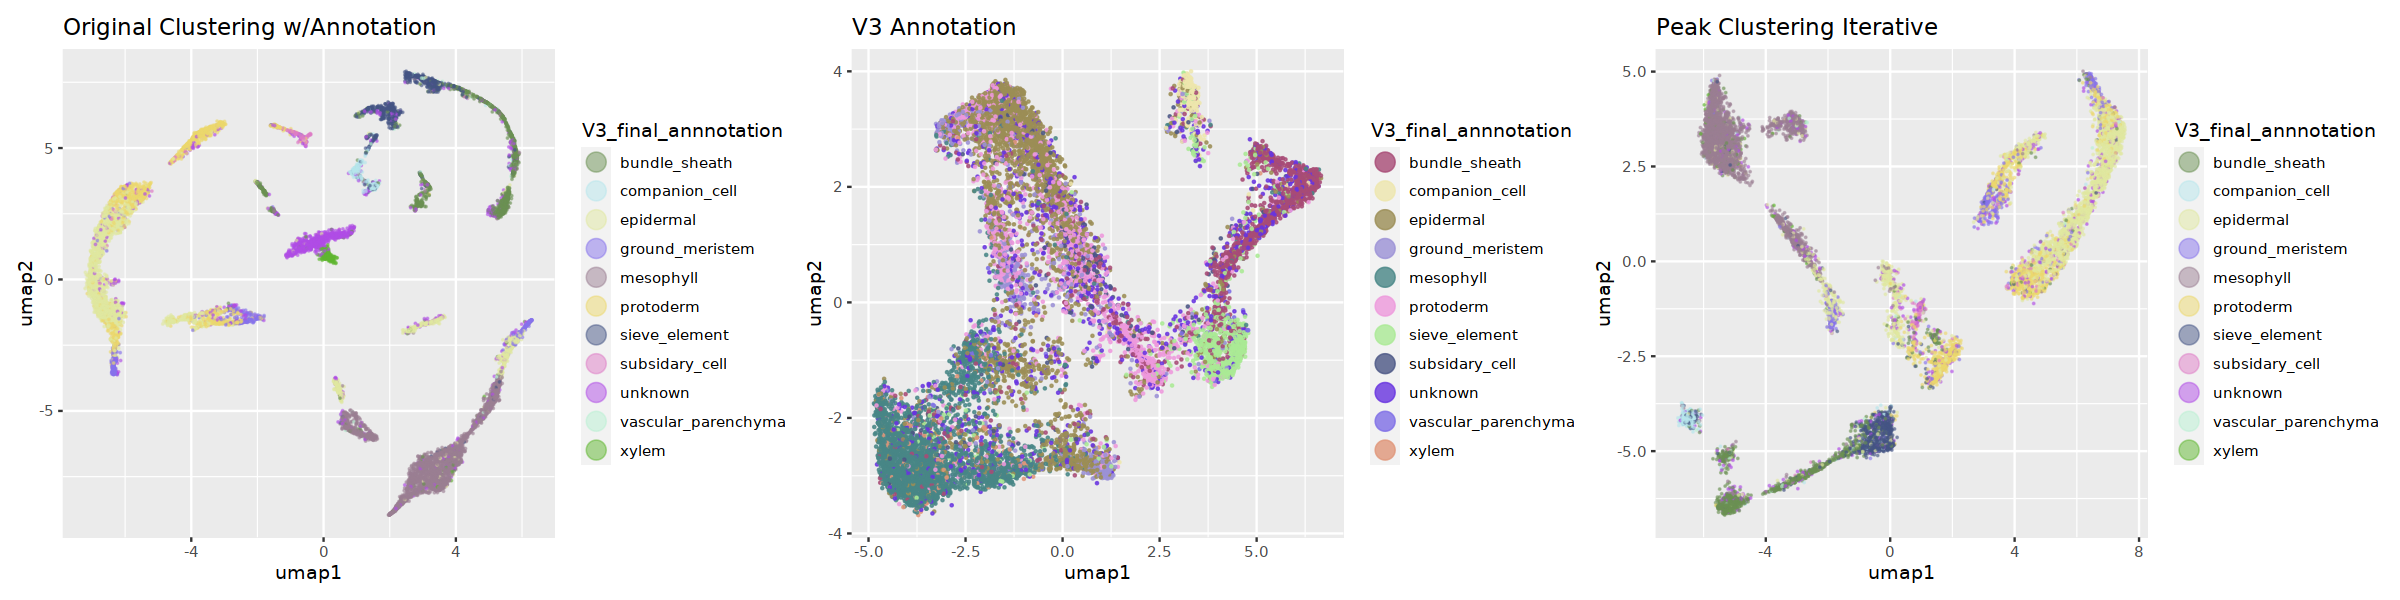

In [82]:

original_clustering + new_coords_onld_annot + peak_call_2_clustering

In [32]:
library("presto")
run_presto <- function(meta_obj, 
                       meta_slot = "Clusters", 
                       cluster_name = "LouvainClusters", 
                       counts_raw="acr_counts_raw"){
    ### Pull the correct meta datafrom the Socrates Object
    sparse_matrix <- meta_obj[[counts_raw]]
    meta_data <- meta_obj[[meta_slot]]
    
    print(head(as_tibble(meta_data)))
        
    ### Read the Giant Sparse Matrix
    loaded_sparse_matric <- read_delim(sparse_matrix, delim='\t', 
                                       col_names = c("gene_name", "barcode", "accessability"), 
                                       col_types = "ccn")
    
    print(head(loaded_sparse_matric))
    combined_large_w_sparse <- loaded_sparse_matric  %>% 
        filter(gene_name != "Annotation")  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        left_join(., meta_data, by = c("barcode" = "cellID"))  %>% 
        filter(is.na(!!sym(cluster_name)) != TRUE)  %>% 
        arrange(!!sym(cluster_name))
    
    #order <- combined_large_w_sparse[!!sym(cluster_name)]

    combined_large_w_sparse <- combined_large_w_sparse  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        mutate(across(accessability, as.numeric))
    
    
    gene_names <- unique(combined_large_w_sparse$gene_name)
    barcodes <- unique(combined_large_w_sparse$barcode)

    combined_large_w_sparse$row <- match(combined_large_w_sparse$gene_name, gene_names)
    combined_large_w_sparse$col <- match(combined_large_w_sparse$barcode, barcodes)


    UIMatrix <- sparseMatrix(i = combined_large_w_sparse$row,
                         j = combined_large_w_sparse$col,
                         x = combined_large_w_sparse$accessability,
                         dimnames=list(gene_names, barcodes))

    print(head(tibble(barcode = unlist(UIMatrix@Dimnames[2]))))
    barcode_tibble <- tibble(barcode = unlist(UIMatrix@Dimnames[2])) %>% 
        left_join(., as_tibble(meta_data), by = c("barcode" = "cellID"))  %>% 
        filter(is.na(total) != TRUE)
    
    print(dim(barcode_tibble))
    print(dim(UIMatrix))
    
    clust_name <- c(cluster_name)
    garbbed_louv_order <- pull(barcode_tibble,!!sym(clust_name))

    sparse_matrix_test <- wilcoxauc(UIMatrix, garbbed_louv_order)
    
    meta_obj[["presto_marker"]] <- sparse_matrix_test
    
    return(meta_obj)
}


Loading required package: data.table


Attaching package: 'data.table'


The following object is masked from 'package:slam':

    rollup


The following object is masked from 'package:GenomicRanges':

    shift


The following object is masked from 'package:IRanges':

    shift


The following objects are masked from 'package:S4Vectors':

    first, second


The following objects are masked from 'package:dplyr':

    between, first, last


The following object is masked from 'package:purrr':

    transpose


The following objects are masked from 'package:reshape2':

    dcast, melt




In [33]:
setwd("/scratch/jpm73279/comparative_single_cell/dev_location")
Sb.subcluster.epidermal.tfidf.clusters$all_genes <- "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sbicolorv5.1.gene.bed"
#bed_intersections <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/zea_mays/Zm.all_mergeed_repds.unique.mpq10.tn5.sorted.bed"
genome_file <- "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sorghum_bicolor_var_BTx623.mainGenome.MtPt.fasta.fai"

### Kernal Corrupted to just linked to the previosly run gene body accessability calculations
tfidf.obj.dob.filt.clusters.counts <- Sb.subcluster.epidermal.tfidf.clusters
tfidf.obj.dob.filt.clusters.counts$acr_counts_raw <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/Sb.gene_counts.output"

## Execute Annotation Attempt #1

library(presto)
Sb.subcluster.tfidf.clusters.final <- run_presto(tfidf.obj.dob.filt.clusters.counts,
           meta_slot = "sub_cluster",
           counts_raw = "acr_counts_raw",
           cluster_name = "LouvainClusters")

# A tibble: 6 × 14
  cellID  total    tss   acrs  ptmt nSites log10…¹ sampl…²  umap1  umap2 doubl…³
  <chr>   <dbl>  <dbl>  <dbl> <dbl>  <dbl>   <dbl> <chr>    <dbl>  <dbl>   <dbl>
1 BC:Z:… 193716 115473 154235     0  30583    4.49 rep1    -2.18  -1.47    0.318
2 BC:Z:… 159908  50092  29336     0  13716    4.14 rep1     2.67  -1.63    0.612
3 BC:Z:… 137820  80881  99700     0  25193    4.40 rep1    -0.248 -1.26    0.576
4 BC:Z:… 116704  44610  44540     0  15274    4.18 rep1    -3.53  -0.903   0.635
5 BC:Z:… 115159  66137  88585     0  22826    4.36 rep1    -2.02  -0.767   0.788
6 BC:Z:…  99224  62412  83029     0  20830    4.32 rep1     4.31   2.25    0.659
# … with 3 more variables: d.type <chr>, LouvainClusters <fct>,
#   Louvain_cluster_safe <chr>, and abbreviated variable names ¹​log10nSites,
#   ²​sampleID, ³​doubletscore
# A tibble: 6 × 3
  gene_name        barcode                                               acces…¹
  <chr>            <chr>                                     

In [34]:
grabbed_top_marker_per_cluster <- top_markers(Sb.subcluster.tfidf.clusters.final$presto_marker, 200)


represented_marker_lst <- list()
for (i in unique(Sb.subcluster.tfidf.clusters.final$sub_cluster$LouvainClusters)) {
    
    make_set <- setNames("geneID",i) 
    markers_present_in_presto <- left_join(grabbed_top_marker_per_cluster, 
                                           marker_list_sb, by = make_set)  %>% 
    dplyr::filter(is.na(chr) != TRUE)  %>% 
    dplyr::select(rank, i, chr:tissue) %>% 
    dplyr::rename("geneID" = i)
    
    represented_marker_lst[[i]] <- markers_present_in_presto
}
                 
represented_marker_lst

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(i)` instead of `i` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


$`23`
# A tibble: 4 × 8
   rank geneID                        chr      start      end name  type  tissue
  <int> <chr>                         <chr>    <dbl>    <dbl> <chr> <chr> <chr> 
1     9 Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676 cah1  meso… axill…
2    42 Sorbiv5.1_pg15531.m1.g        Chr03  3341071  3347117 me3_… bund… axill…
3    75 Sobic.004G062500              Chr04  5115447  5120789 bm5   vasc… axill…
4   157 Sobic.010G160700              Chr10 48834723 48842334 pepc1 meso… axill…

$`17`
# A tibble: 1 × 8
   rank geneID           chr      start      end name  type               tissue
  <int> <chr>            <chr>    <dbl>    <dbl> <chr> <chr>              <chr> 
1   181 Sobic.007G211200 Chr07 67406141 67408727 pan1  subsidary_mother_… axill…

$`15`
# A tibble: 3 × 8
   rank geneID                       chr      start      end name   type  tissue
  <int> <chr>                        <chr>    <dbl>    <dbl> <chr>  <chr> <chr> 
1     2 Sorbiv5.1_pg9159.m1.g        Chr06 41574374 41588764 ba2    axil… axill…
2    94 Sorbiv5.1_pg24873.valid.m3.g Chr02  2529322  2534592 ZmAAP… xyle… axill…
3   125 Sobic.001G075101             Chr01  5763796  5774227 knox8  SAM,… axill…

$`24`
# A tibble: 4 × 8
   rank geneID                        chr      start      end name  type  tissue
  <int> <chr>                         <chr>    <dbl>    <dbl> <chr> <chr> <chr> 
1    55 Sobic.004G058700              Chr04  4774060  4777174 ZmAPL prot… axill…
2    59 Sorbiv5.1_pg26238.m1.g        Chr02 19991876 19997282 hp2   prot… axill…
3    61 Sorbiv5.1_pg29247.valid.m13.g Chr09 53708860 53712249 ZmAA… xyle… axill…
4    97 Sorbiv5.1_pg4644.valid.m4.g   Chr01 74647099 74653265 ZmLR… prot… axill…

$`3`
# A tibble: 4 × 8
   rank geneID                      chr      start      end name    type  tissue
  <int> <chr>                       <chr>    <dbl>    <dbl> <chr>   <chr> <chr> 
1     3 Sobic.002G207900            Chr02 61233338 61239219 gl1     epid… axill…
2    29 Sorbiv5.1_pg9159.m1.g       Chr06 41574374 41588764 ba2     axil… axill…
3    83 Sobic.002G343500            Chr02 72301461 72308725 ZmCPK3… guar… axill…
4   138 Sorbiv5.1_pg5044.valid.m7.g Chr01 66616555 66619678 bk1     vasc… axill…

$`9`
# A tibble: 3 × 8
   rank geneID                        chr      start      end name  type  tissue
  <int> <chr>                         <chr>    <dbl>    <dbl> <chr> <chr> <chr> 
1     1 Sobic.010G160700              Chr10 48834723 48842334 pepc1 meso… axill…
2     3 Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676 cah1  meso… axill…
3    92 Sobic.005G042000              Chr05  3935393  3936843 ssu2… bund… axill…

$`10`
# A tibble: 3 × 8
   rank geneID                chr      start      end name  type          tissue
  <int> <chr>                 <chr>    <dbl>    <dbl> <chr> <chr>         <chr> 
1     1 Sobic.002G207900      Chr02 61233338 61239219 gl1   epidermis     axill…
2   107 Sorbiv5.1_pg9159.m1.g Chr06 41574374 41588764 ba2   axillary_mer… axill…
3   193 Sobic.001G537300      Chr01 84195608 84203525 rld1  SAM,leaf_pri… axill…

$`2`
# A tibble: 3 × 8
   rank geneID           chr      start      end name           type      tissue
  <int> <chr>            <chr>    <dbl>    <dbl> <chr>          <chr>     <chr> 
1     1 Sobic.002G207900 Chr02 61233338 61239219 gl1            epidermis axill…
2   145 Sobic.009G162000 Chr09 55658168 55661565 gpat11__gpat12 epidermi… axill…
3   152 Sobic.006G279400 Chr06 62388932 62391254 vnd7           protoxyl… axill…

$`7`
# A tibble: 3 × 8
   rank geneID           chr      start      end name  type               tissue
  <int> <chr>            <chr>    <dbl>    <dbl> <chr> <chr>              <chr> 
1     1 Sobic.002G207900 Chr02 61233338 61239219 gl1   epidermis          axill…
2    56 Sobic.001G537300 Chr01 84195608 84203525 rld1  SAM,leaf_primordi… axill…
3   153 Sobic.008G193300 Chr08 65745228 65750046 sut2  companion_cells,x… axill…

$`22`
# A tibble: 3 × 8
   rank geneID           chr 

In [31]:
gathered_markers <- bind_rows(represented_marker_lst, .id = "LouvainCluster")  %>% 
    arrange(LouvainCluster, rank)

gathered_markers

LouvainCluster rank geneID                        chr   start    end     
1   1                1  Sobic.010G160700              Chr10 48834723 48842334
2   1               11  Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676
3   1              111  Sobic.005G042000              Chr05  3935393  3936843
4   10               2  Sobic.002G207900              Chr02 61233338 61239219
5   10             106  Sobic.001G537300              Chr01 84195608 84203525
6   10             114  Sorbiv5.1_pg15531.m1.g        Chr03  3341071  3347117
7   11             144  Sobic.007G211200              Chr07 67406141 67408727
8   12               8  Sobic.002G207900              Chr02 61233338 61239219
9   12              17  Sorbiv5.1_pg15531.m1.g        Chr03  3341071  3347117
10  12             115  Sobic.009G162000              Chr09 55658168 55661565
11  13               1  Sobic.010G160700              Chr10 48834723 48842334
12  13             144  Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676
13  14              37  Sorbiv5.1_pg26238.m1.g        Chr02 19991876 19997282
14  14              62  Sorbiv5.1_pg29247.valid.m13.g Chr09 53708860 53712249
15  14              92  Sobic.001G488700              Chr01 80047831 80054246
16  14             166  Sobic.004G058700              Chr04  4774060  4777174
17  15              25  Sobic.002G207900              Chr02 61233338 61239219
18  15              44  Sobic.001G075101              Chr01  5763796  5774227
19  15              95  Sorbiv5.1_pg5044.valid.m7.g   Chr01 66616555 66619678
20  15             198  Sorbiv5.1_pg9159.m1.g         Chr06 41574374 41588764
21  16              31  Sobic.002G032500              Chr02  3002965  3011531
22  16             126  Sobic.007G211200              Chr07 67406141 67408727
23  16             134  Sobic.001G145200              Chr01 11750927 11755977
24  16             182  Sorbiv5.1_pg7389.valid.m23.g  Chr06 60678690 60686342
25  17               8  Sorbiv5.1_pg9159.m1.g         Chr06 41574374 41588764
26  17               9  Sobic.007G141200              Chr07 60395810 60403219
27  17              36  Sobic.005G042000              Chr05  3935393  3936843
28  19               2  Sobic.010G160700              Chr10 48834723 48842334
29  19               3  Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676
30  19              59  Sobic.004G062500              Chr04  5115447  5120789
⋮   ⋮              ⋮    ⋮                             ⋮     ⋮        ⋮       
77  31               3  Sorbiv5.1_pg5044.valid.m7.g   Chr01 66616555 66619678
78  31               8  Sorbiv5.1_pg9159.m1.g         Chr06 41574374 41588764
79  31             107  Sobic.002G343500              Chr02 72301461 72308725
80  31             192  Sobic.002G207900              Chr02 61233338 61239219
81  32               7  Sobic.002G207900              Chr02 61233338 61239219
82  32              61  Sorbiv5.1_pg18563.valid.m1.g  Chr07  6900132  6906079
83  33              20  Sobic.008G112200              Chr08 54920473 54923616
84  33             121  Sobic.001G327900              Chr01 65660828 65664161
85  33             124  Sorbiv5.1_pg9159.m1.g         Chr06 41574374 41588764
86  34              60  Sorbiv5.1_pg1793.valid.m1.g   Chr01 13056142 13064330
87  34              71  Sobic.002G083600              Chr02  8962876  8967240
88  34             120  Sobic.007G141200              Chr07 60395810 60403219
89  4                1  Sobic.002G207900              Chr02 61233338 61239219
90  4              151  Sobic.009G162000              Chr09 55658168 55661565
91  4              159  Sobic.008G193300              Chr08 65745228 65750046
92  5                1  Sobic.010G160700              Chr10 48834723 48842334
93  5                6  Sobic.005G042000              Chr05  3935393  3936843
94  5               23  Sorbiv5.1_pg24873.valid.m3.g  Chr02  2529322  2534592
95  5               41  Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676
96  5              166  So

In [32]:

write_delim(gathered_markers, 
            "/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/V3_annotations/Sb_leaf.merged_replicates.peak_clustering.txt", 
            col_names = TRUE, quote = "none", delim = "\t")

gathered_markers

LouvainCluster rank geneID                        chr   start    end     
1   1                1  Sobic.010G160700              Chr10 48834723 48842334
2   1               11  Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676
3   1              111  Sobic.005G042000              Chr05  3935393  3936843
4   10               2  Sobic.002G207900              Chr02 61233338 61239219
5   10             106  Sobic.001G537300              Chr01 84195608 84203525
6   10             114  Sorbiv5.1_pg15531.m1.g        Chr03  3341071  3347117
7   11             144  Sobic.007G211200              Chr07 67406141 67408727
8   12               8  Sobic.002G207900              Chr02 61233338 61239219
9   12              17  Sorbiv5.1_pg15531.m1.g        Chr03  3341071  3347117
10  12             115  Sobic.009G162000              Chr09 55658168 55661565
11  13               1  Sobic.010G160700              Chr10 48834723 48842334
12  13             144  Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676
13  14              37  Sorbiv5.1_pg26238.m1.g        Chr02 19991876 19997282
14  14              62  Sorbiv5.1_pg29247.valid.m13.g Chr09 53708860 53712249
15  14              92  Sobic.001G488700              Chr01 80047831 80054246
16  14             166  Sobic.004G058700              Chr04  4774060  4777174
17  15              25  Sobic.002G207900              Chr02 61233338 61239219
18  15              44  Sobic.001G075101              Chr01  5763796  5774227
19  15              95  Sorbiv5.1_pg5044.valid.m7.g   Chr01 66616555 66619678
20  15             198  Sorbiv5.1_pg9159.m1.g         Chr06 41574374 41588764
21  16              31  Sobic.002G032500              Chr02  3002965  3011531
22  16             126  Sobic.007G211200              Chr07 67406141 67408727
23  16             134  Sobic.001G145200              Chr01 11750927 11755977
24  16             182  Sorbiv5.1_pg7389.valid.m23.g  Chr06 60678690 60686342
25  17               8  Sorbiv5.1_pg9159.m1.g         Chr06 41574374 41588764
26  17               9  Sobic.007G141200              Chr07 60395810 60403219
27  17              36  Sobic.005G042000              Chr05  3935393  3936843
28  19               2  Sobic.010G160700              Chr10 48834723 48842334
29  19               3  Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676
30  19              59  Sobic.004G062500              Chr04  5115447  5120789
⋮   ⋮              ⋮    ⋮                             ⋮     ⋮        ⋮       
77  31               3  Sorbiv5.1_pg5044.valid.m7.g   Chr01 66616555 66619678
78  31               8  Sorbiv5.1_pg9159.m1.g         Chr06 41574374 41588764
79  31             107  Sobic.002G343500              Chr02 72301461 72308725
80  31             192  Sobic.002G207900              Chr02 61233338 61239219
81  32               7  Sobic.002G207900              Chr02 61233338 61239219
82  32              61  Sorbiv5.1_pg18563.valid.m1.g  Chr07  6900132  6906079
83  33              20  Sobic.008G112200              Chr08 54920473 54923616
84  33             121  Sobic.001G327900              Chr01 65660828 65664161
85  33             124  Sorbiv5.1_pg9159.m1.g         Chr06 41574374 41588764
86  34              60  Sorbiv5.1_pg1793.valid.m1.g   Chr01 13056142 13064330
87  34              71  Sobic.002G083600              Chr02  8962876  8967240
88  34             120  Sobic.007G141200              Chr07 60395810 60403219
89  4                1  Sobic.002G207900              Chr02 61233338 61239219
90  4              151  Sobic.009G162000              Chr09 55658168 55661565
91  4              159  Sobic.008G193300              Chr08 65745228 65750046
92  5                1  Sobic.010G160700              Chr10 48834723 48842334
93  5                6  Sobic.005G042000              Chr05  3935393  3936843
94  5               23  Sorbiv5.1_pg24873.valid.m3.g  Chr02  2529322  2534592
95  5               41  Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676
96  5              166  So

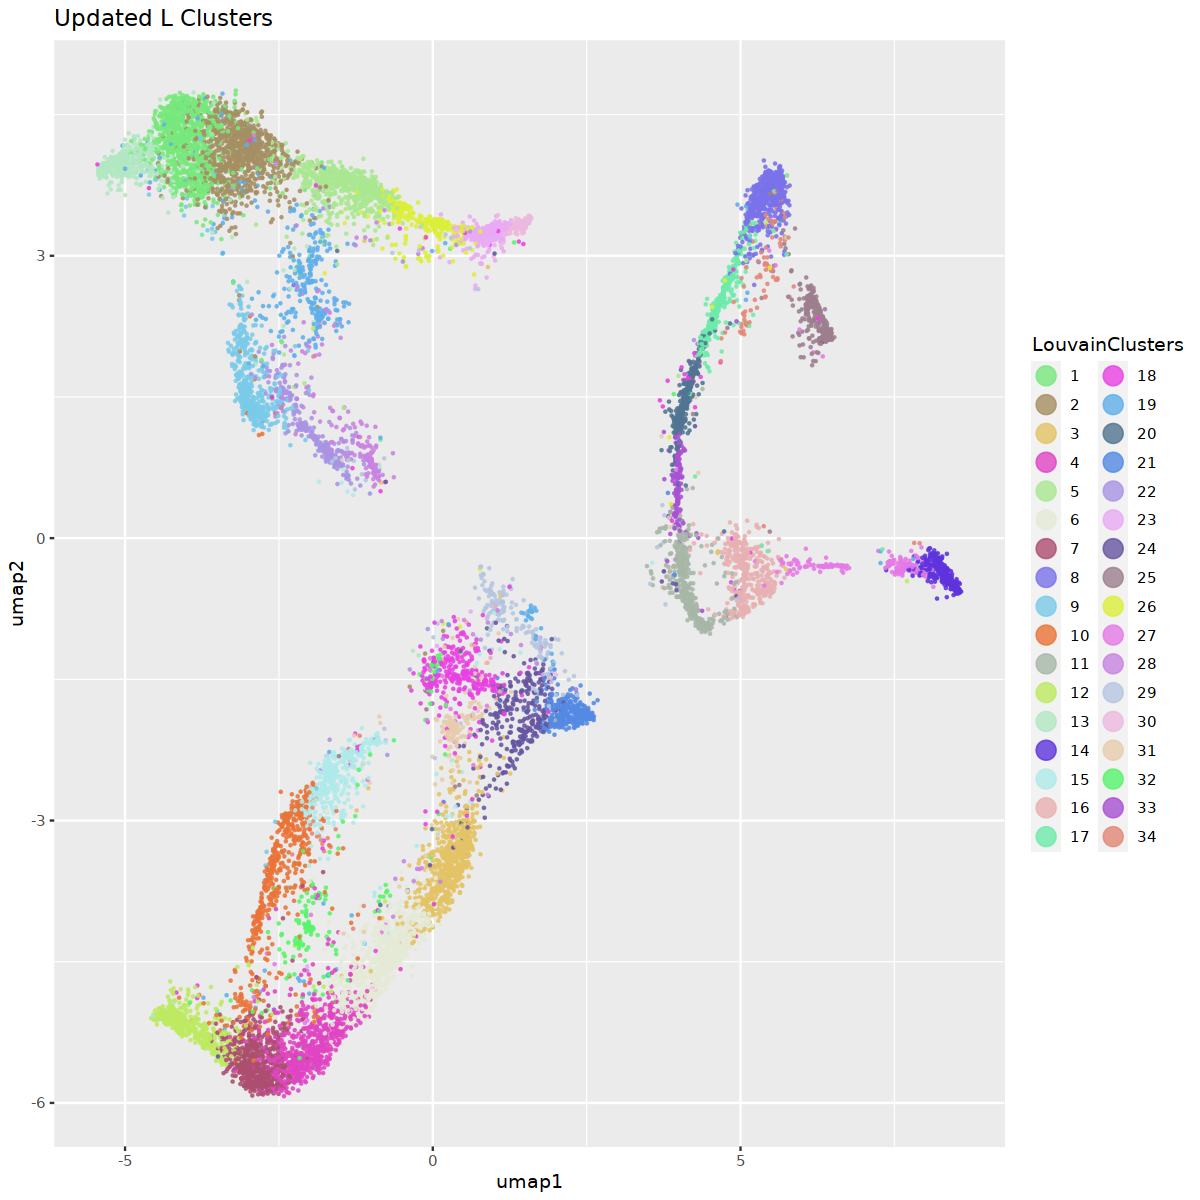

In [33]:
options(repr.plot.width=10, repr.plot.height=10)
new_clusters

In [34]:
prefix

[1] "Sb_leaf.peak_clustering"

In [35]:
saveRDS(Sb.subcluster.epidermal.tfidf.clusters, file = paste0(output_location,prefix, ".SVD.full.rds"))